**Run celltype quality control and annotation II**

In [1]:
# load packages
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from harmony import harmonize
import seaborn as sns
from numba import config

import scipy.io as sio
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from ABCA7lof2.qc import filter_logcounts, compute_thresh, filter_clusters

config.THREADING_LAYER = 'workqueue'

#### Load & subset the data

In [3]:
# load data
meta = np.load('./processed_data/single_cell/filtered_meta.npy', allow_pickle=True)
meta_names = np.load('./processed_data/single_cell/meta_names.npy', allow_pickle=True)
features = np.load('./processed_data/single_cell/features.npy')
counts = np.memmap('./processed_data/single_cell/filtered_counts.npy', mode='r+', shape=(meta.shape[0], features.shape[0]), dtype='int16')
index_genes = np.load('./processed_data/single_cell/marker_indices.npy')
feature_index = np.load('./processed_data/single_cell/features_proteincoding_index.npy')
projections = np.load('./processed_data/single_cell/projected_matrix.npy')
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='r+', shape=counts.shape, dtype='float')

In [4]:
meta[:,0] = [meta[i,0]+'_'+str(i) for i in range(len(meta[:,0]))] 

In [5]:
# subset
index_all = meta[:,np.where(meta_names=='keep_cells_gaussian')[0][0]].astype(bool)

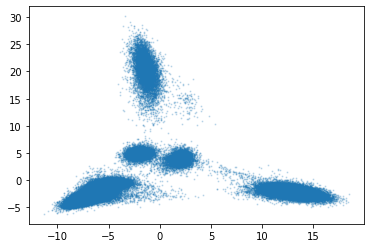

In [6]:
plt.scatter(projections[index_all,0], projections[index_all,1], s=1, alpha=0.2)

#### Perform batch correction

In [7]:
# get projections
projections_indexed = projections[index_all]

# metadata
meta_indexed = meta[index_all]
meta_indexed = pd.DataFrame(meta_indexed)
meta_indexed.columns = meta_names
meta_indexed.index = meta_indexed['barcodes']
meta_indexed = pd.get_dummies(meta_indexed, columns=['projid'], drop_first=True)

L = list(meta_indexed.columns[[x.split('_')[0]=='projid' for x in meta_indexed.columns]])

# perform batch correction with harmony
Z = harmonize(projections_indexed, meta_indexed, batch_key = L)

/state/partition1/slurm_tmp/23708770.0.0/ipykernel_2786141/957316070.py:9: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  meta_indexed = pd.get_dummies(meta_indexed, columns=['projid'], drop_first=True)


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


#### Filter the logcounts to only include the marker genes

In [8]:
# get markers and filter the logcounts to only include marker gene logcounts
marker_temp = np.memmap('./processed_data/single_cell/marker_temp.npy', mode='w+', shape=(np.sum(index_all), len(index_genes)), dtype='float')
filter_logcounts(marker_temp[:2], logcounts[:2], np.where(index_all)[0], index_genes[:2])

In [9]:
# get markers and filter the logcounts to only include marker gene logcounts
marker_temp = np.memmap('./processed_data/single_cell/marker_temp.npy', mode='w+', shape=(np.sum(index_all), len(index_genes)), dtype='float')
filter_logcounts(marker_temp, logcounts, np.where(index_all)[0], index_genes)

#### Make the Adata object

In [10]:
# make adata object

# features
FEATURES_df = pd.DataFrame(features[index_genes])
FEATURES_df.columns = ['Gene', 'ID']
FEATURES_df.index = FEATURES_df['Gene']

# counts
COUNTS_df = pd.DataFrame(marker_temp)
COUNTS_df.columns = FEATURES_df['Gene']

adata = sc.AnnData(X=COUNTS_df, obs=meta_indexed, var=FEATURES_df)
adata.obsm['X_pca'] = Z
adata.var_names_make_unique(join='.')
adata.obs_names_make_unique(join='.')

#### Compute the neighborhood graph and perform leiden clustering

In [11]:
# compute neighborhood graph and perform leiden clustering
print('neighborhood graph')
sc.pp.neighbors(adata, use_rep='X_pca', n_pcs=50)
print('leiden clustering')
sc.tl.leiden(adata, resolution=1)
print('UMAP')
sc.tl.umap(adata, min_dist=0.5, spread=1.0, n_components=2, maxiter=None, alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)

neighborhood graph


/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDepr

leiden clustering
UMAP


#### Show UMAP projection plots

/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


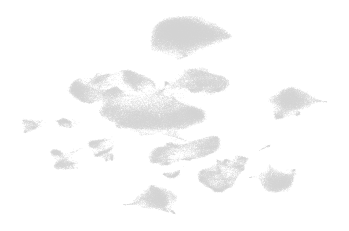

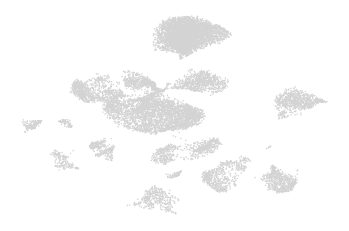

In [12]:
# plot by sequencing batch
sc.pl.umap(adata[adata.obs['seq_batch']=='JBM'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata[adata.obs['seq_batch']!='JBM'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


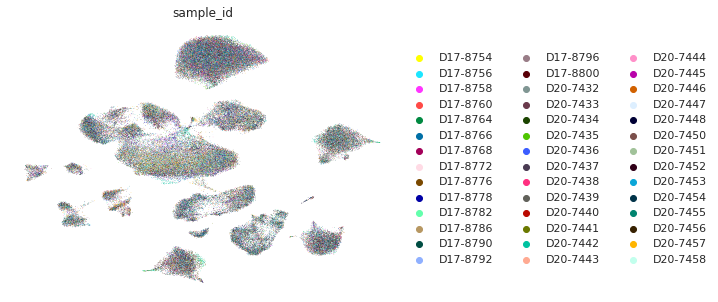

In [13]:
sns.set(rc={'figure.figsize':(7,5)})

sc.pl.umap(adata, color=['sample_id'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


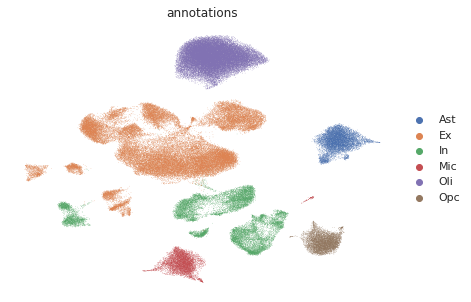

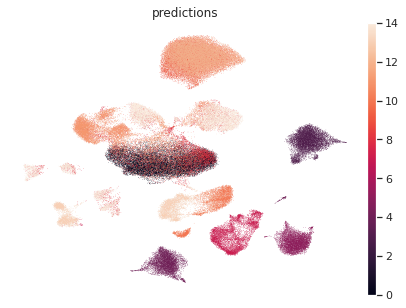

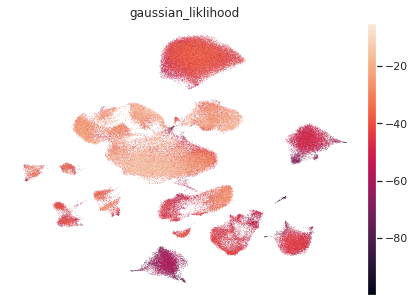

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


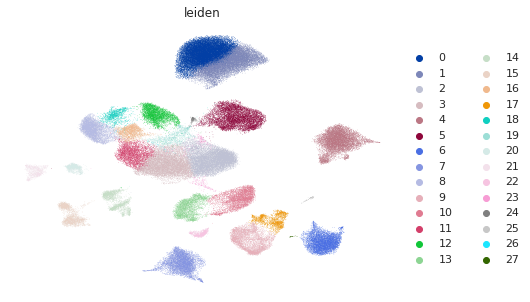

In [14]:
sns.set(rc={'figure.figsize':(7,5)})

# plot UMAPs
sc.pl.umap(adata, color=['annotations'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata, color=['predictions'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata, color=['gaussian_liklihood'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)
sc.pl.umap(adata, color=['leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=False)

#### Perform gene rankings per cluster & assign major cell types

In [15]:
# rank genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is h

In [16]:
# assign marker scores to infer celltypes
markers = pd.read_csv('./processed_data/single_cell/brain_marker_genes.csv')

scores = adata.uns['rank_genes_groups']['logfoldchanges']
names = adata.uns['rank_genes_groups']['names']
pvals = adata.uns['rank_genes_groups']['pvals_adj']

sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

celltypes = np.unique(markers['major_celltype'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['major_celltype']==np.unique(celltypes)[i]]['marker'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


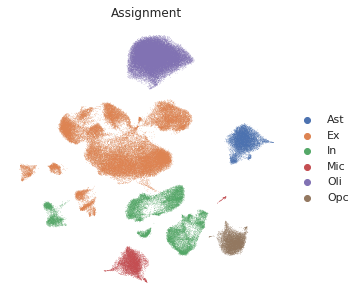

In [17]:
# plot assignments in UMAP space

width = 5
height = 5
sns.set(rc = {'figure.figsize':(width, height)})
out = sc.pl.umap(adata, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

#### Perform subclustering by major cell type

In [18]:
# perform subclustering by major assigned cell type
for i in np.unique(adata.obs['Assignment']):
    print(i)
    sc.tl.leiden(adata, resolution=2, restrict_to=('Assignment', [i]), key_added=i+'_leiden')
#out = sc.pl.umap(adata, color=['sub_leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


Ast
Ex
In
Mic
Oli
Opc


#### Show which subclusters should be removed

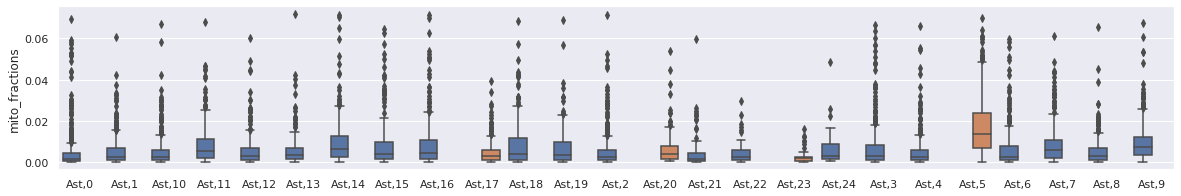

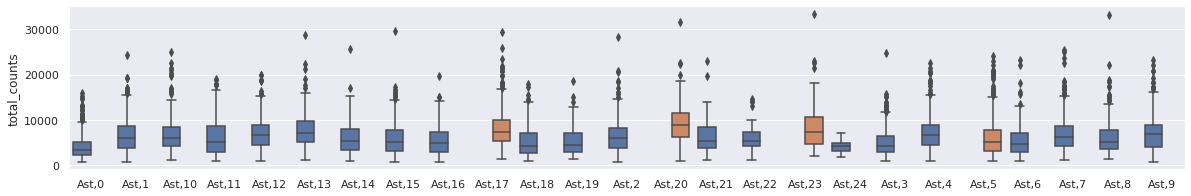

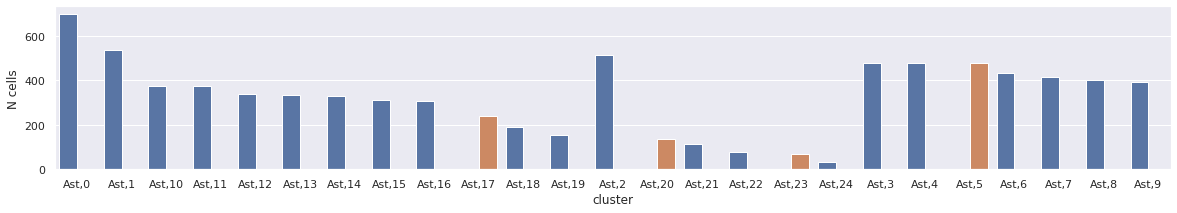

/state/partition1/slurm_tmp/23708770.0.0/ipykernel_2786141/2747256604.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


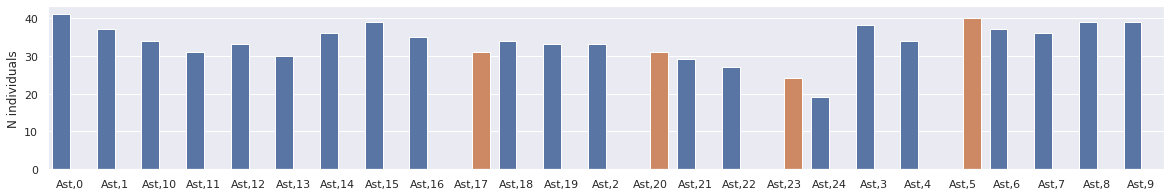

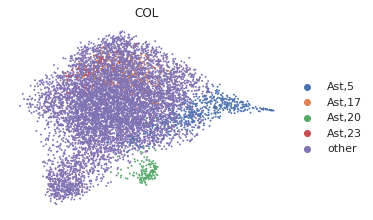

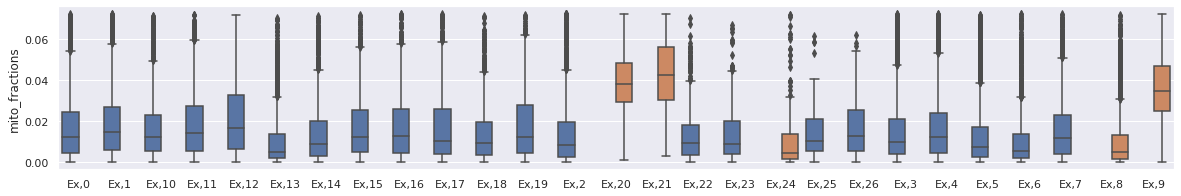

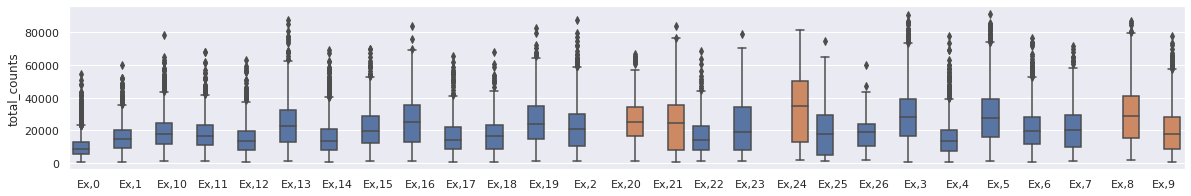

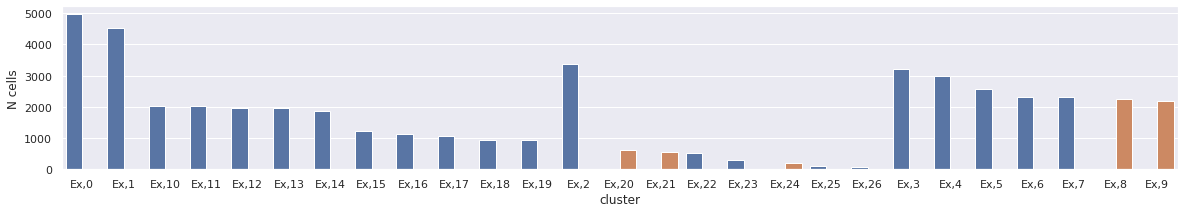

/state/partition1/slurm_tmp/23708770.0.0/ipykernel_2786141/2747256604.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


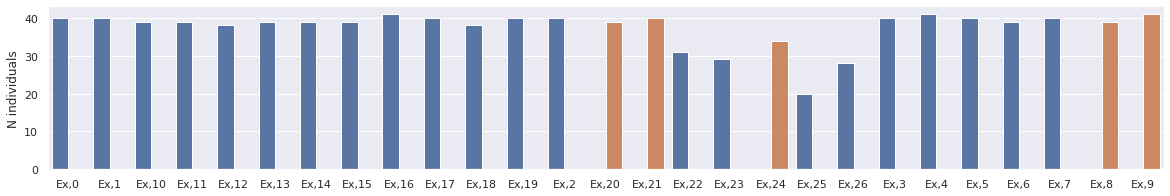

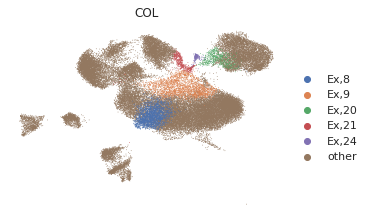

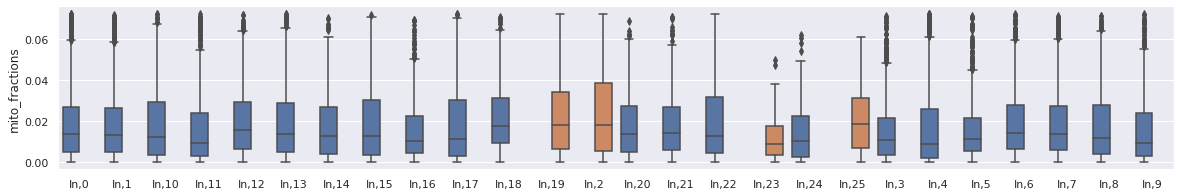

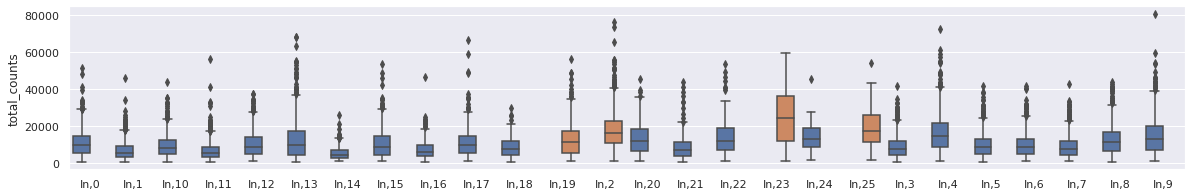

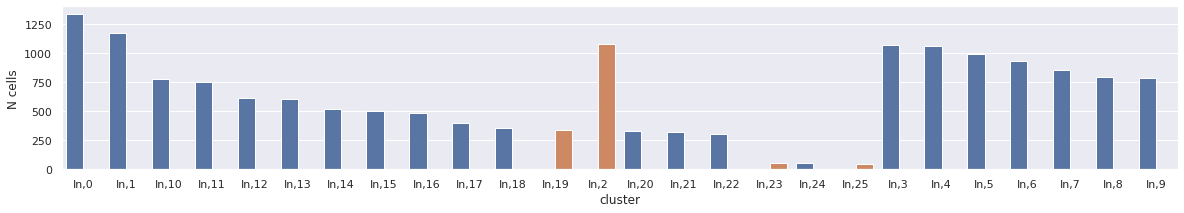

/state/partition1/slurm_tmp/23708770.0.0/ipykernel_2786141/2747256604.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


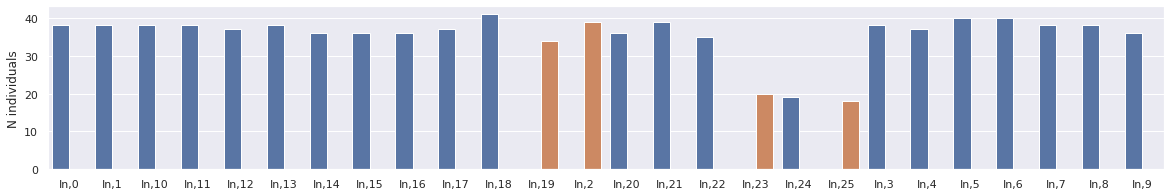

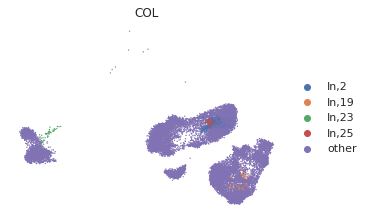

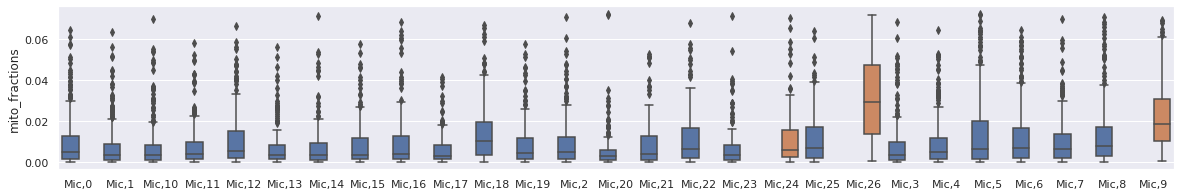

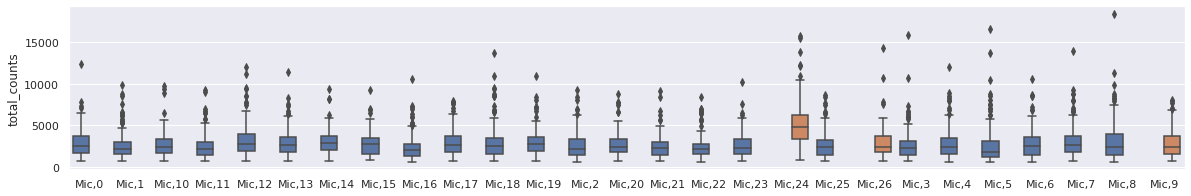

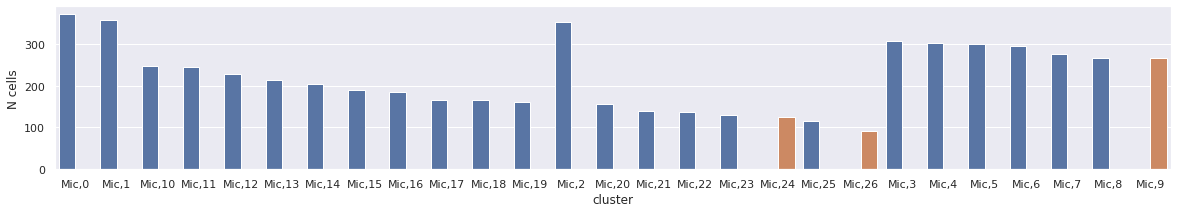

/state/partition1/slurm_tmp/23708770.0.0/ipykernel_2786141/2747256604.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


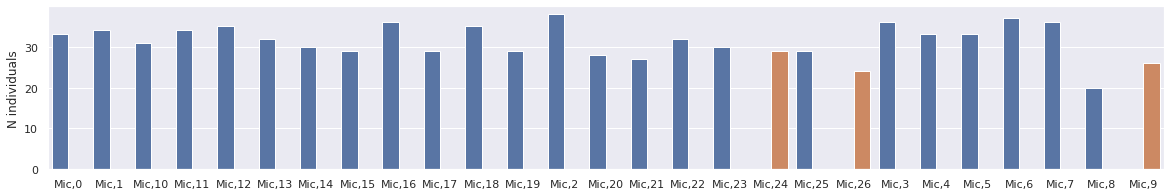

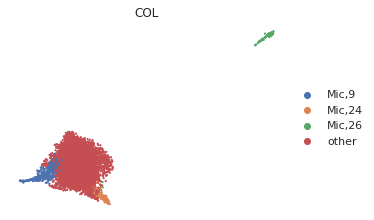

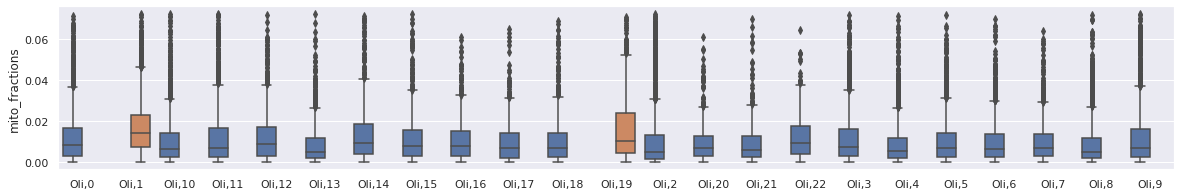

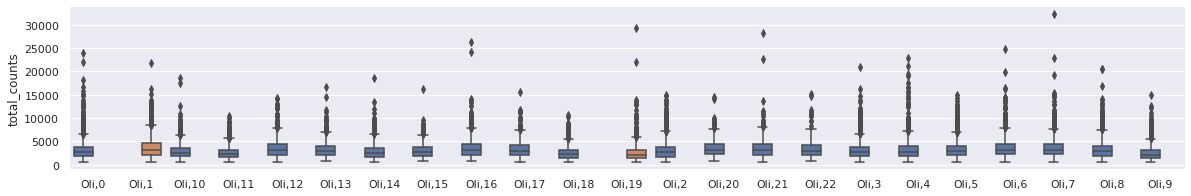

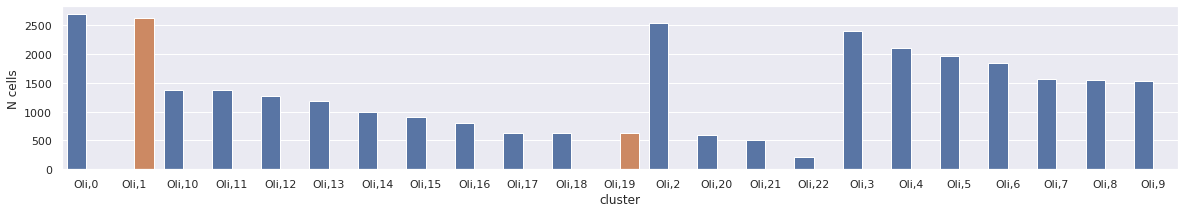

/state/partition1/slurm_tmp/23708770.0.0/ipykernel_2786141/2747256604.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


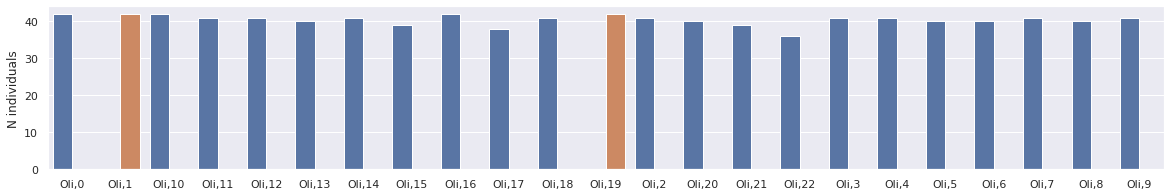

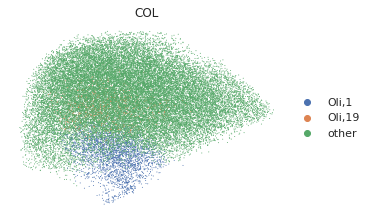

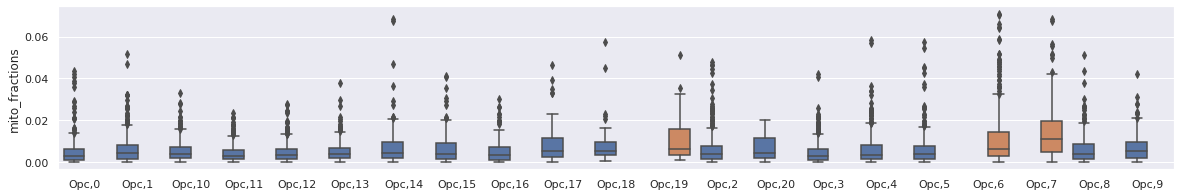

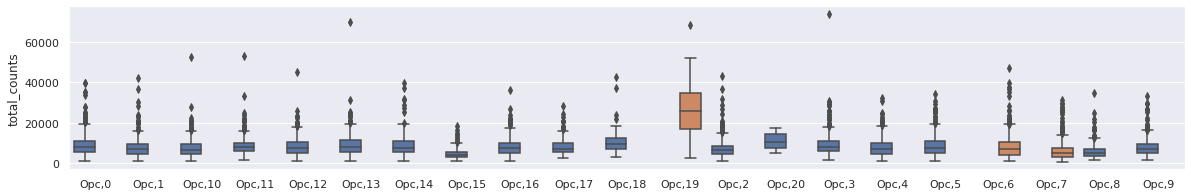

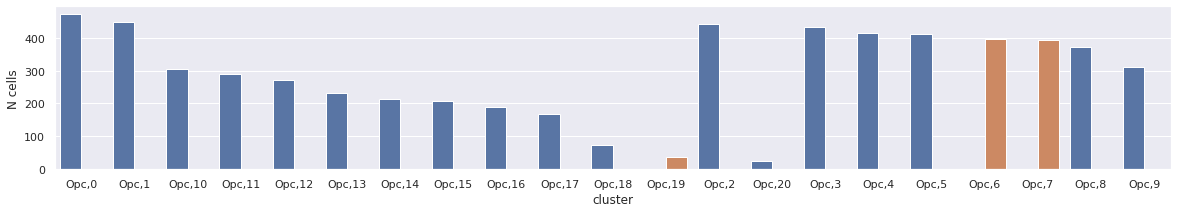

/state/partition1/slurm_tmp/23708770.0.0/ipykernel_2786141/2747256604.py:58: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  temp.obs['COL'] = np.array([x if x in set(remove) else 'other' for x in temp.obs[grp]])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


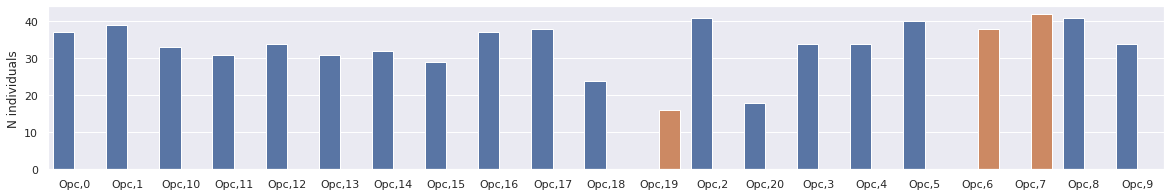

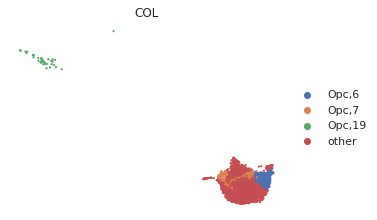

In [20]:
remove = list()
for i in np.unique(adata.obs['Assignment']):
    filter_clusters(adata[adata.obs['Assignment']==i], i+'_leiden', remove)


#### Remove cells that belong to the clusters in orange

In [21]:
out = []
for i in np.unique(adata.obs['Assignment']):
    out.append([x in set(remove) for x in adata.obs[i+'_leiden']])
    
temp = np.vstack(out)
keep = np.sum(temp, axis=0)==0

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


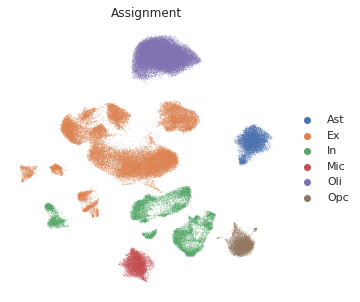

In [22]:
# plot assignments in UMAP space after removing clusters above

width = 5
height = 5
sns.set(rc = {'figure.figsize':(width, height)})
out = sc.pl.umap(adata[keep], color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

#### Remove cells from individuals that have very few cells

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


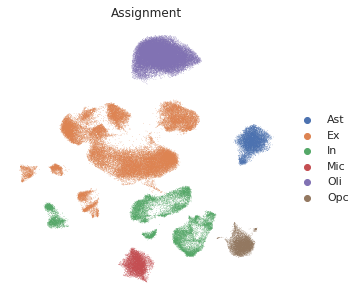

In [23]:
# remove individuals that have very few cells after QC
adata_keep = adata[keep]
tt = adata_keep.obs['sample_id']
assign = adata_keep.obs['Assignment']
x, y = np.unique(tt, return_counts=True)
keep_ind = set(x[y>500])
adata_keep2 = adata_keep[[x in keep_ind for x in adata_keep.obs['sample_id']]]
out = sc.pl.umap(adata_keep2, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

#### Recluster & Reannotate after removing cells

In [24]:
print('neighborhood graph')
sc.pp.neighbors(adata_keep2, use_rep='X_pca', n_pcs=50)
print('UMAP')
sc.tl.umap(adata_keep2, min_dist=.5, spread=1, n_components=2, maxiter=None, alpha=1.0, gamma=1.0, negative_sample_rate=5, init_pos='spectral', random_state=0, a=None, b=None, copy=False, method='umap', neighbors_key=None)

neighborhood graph
UMAP


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


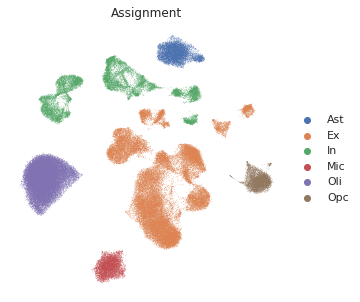

In [25]:
out = sc.pl.umap(adata_keep2, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

In [26]:
print('leiden clustering')
sc.tl.leiden(adata_keep2, resolution=1)

leiden clustering


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


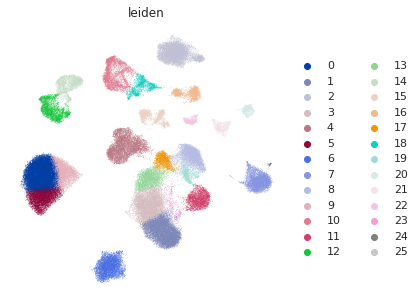

In [27]:
out = sc.pl.umap(adata_keep2, color=['leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

In [28]:
# rank genes
sc.tl.rank_genes_groups(adata_keep2, 'leiden', method='t-test')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is h

In [29]:
# assign marker scores to infer celltypes
markers = pd.read_csv('./processed_data/single_cell/brain_marker_genes.csv')

scores = adata_keep2.uns['rank_genes_groups']['logfoldchanges']
names = adata_keep2.uns['rank_genes_groups']['names']
pvals = adata_keep2.uns['rank_genes_groups']['pvals_adj']

sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

celltypes = np.unique(markers['major_celltype'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['major_celltype']==np.unique(celltypes)[i]]['marker'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 
        
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata_keep2.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata_keep2.obs['leiden'])]

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


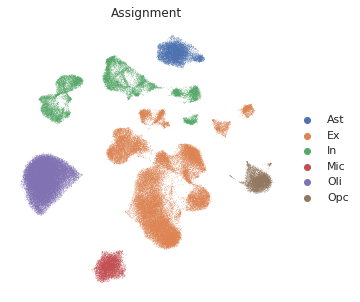

In [30]:
out = sc.pl.umap(adata_keep2, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)

#### plot the per-cluster cell type enrichments

/state/partition1/slurm_tmp/23708770.0.0/ipykernel_2786141/610373786.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


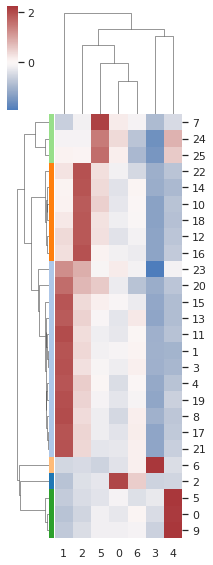

In [31]:
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(np.unique(assignments)))]
dictionary = dict(zip(np.unique(assignments), colors))
sns.clustermap(celltype_scores, row_colors = [dictionary[x] for x in assignments], z_score=0, cmap="vlag", center=0, figsize=(3,8))


In [32]:
kept_barcodes = set(adata_keep2.obs['barcodes'])
index_all = [cell in kept_barcodes for cell in meta[:,0]]

In [33]:
np.sum(index_all)/len(index_all)

0.7868689190224469

#### Save results to sparse-matrix

In [35]:
# save to sparse matrix 
counts_sparse = csr_matrix(counts[index_all][:,feature_index])
sio.mmwrite("./processed_data/single_cell/counts.mtx",counts_sparse)

In [36]:
logcounts_sparse = csr_matrix(logcounts[index_all][:,feature_index])
sio.mmwrite("./processed_data/single_cell/logcounts.mtx",logcounts_sparse)

In [37]:
# save feature data
df = pd.DataFrame(features[feature_index])
df.to_csv("./processed_data/single_cell/rowData.csv")

In [39]:
# save obs data
df = pd.DataFrame(meta[index_all])
df.columns = meta_names
df['annotations2'] = np.array(adata_keep2.obs['Assignment'])
df['leiden_clusters'] = np.array(adata_keep2.obs['leiden'])
df['x'] = adata_keep2.obsm['X_umap'][:,0]
df['y'] = adata_keep2.obsm['X_umap'][:,1]   
df.to_csv("./processed_data/single_cell/colData.csv")

In [40]:
# save celltype score info
df = pd.DataFrame(celltype_scores)
df.columns = celltypes
df.to_csv("./processed_data/single_cell/celltype_scores.csv")

In [42]:
print('done')

done
